<a href="https://colab.research.google.com/github/Xianhui-He/Raclette-Group-2-ECoG-Motor-Imagery/blob/main/code/TFA_Hanif_Xianhui.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Time Frequency Analysis - Hanif R / Xianhui H - Raclette 2

### Neuromatch Academy - July 2022

# Dataset Preprocessing

Step-by-Step Details:

1. Dataset Retrieval
2. Packages Installation
3. Import Related Packages
4. Load the Dataset
5. Pick Region-of-Interest (ROI) Electrodes


In [11]:
# @title Dataset Retrieval

import os, requests

fname = 'motor_imagery.npz'
url = "https://osf.io/ksqv8/download"

if not os.path.isfile(fname):
  try:
    r = requests.get(url)
  except requests.ConnectionError:
    print("!!! Failed to download data !!!")
  else:
    if r.status_code != requests.codes.ok:
      print("!!! Failed to download data !!!")
    else:
      with open(fname, "wb") as fid:
        fid.write(r.content)

In [12]:
# @title Packages Handling

# Install Non-Built-In Packages

!pip install mne --quiet

# Import Packages

import numpy as np
from matplotlib import pyplot as plt
from scipy import signal

import mne
from mne import create_info, EpochsArray
from mne.io import RawArray
from mne.baseline import rescale
from mne.time_frequency import (tfr_multitaper, tfr_stockwell, tfr_morlet, tfr_array_morlet)
from mne.viz import centers_to_edges

from matplotlib import colors
from matplotlib import rcParams
from matplotlib import pyplot as plt

In [13]:
# @title Dataset Loading

alldat = np.load(fname, allow_pickle=True)['dat']

In [14]:
# @title  ROI Electrodes Selection (Post Central & Precentral Gyrus)

electrode_roi = []

# Iterate for Each Subject
for subject_index, subject in enumerate(alldat):

  electrode_indexes_precentral = []
  electrode_indexes_postcentral = []

  for gyrus_index, gyrus in enumerate(subject[0]['gyrus']):
    if gyrus == 'Precentral Gyrus':
      electrode_indexes_precentral.append(gyrus_index)
    elif gyrus == 'Postcentral Gyrus':
      electrode_indexes_postcentral.append(gyrus_index)

  electrode_roi.append(electrode_indexes_precentral + electrode_indexes_postcentral)

  print('\033[1m' + 'Subject {}:'.format(subject_index) + '\033[0m' + """\n  Precentral Gyrus: {}\n  Postcentral Gyrus: {}""".format(electrode_indexes_precentral,electrode_indexes_postcentral))

Subject 0:
  Precentral Gyrus: [5, 6, 7, 12, 20, 27, 28, 35, 36, 41, 42]
  Postcentral Gyrus: [13, 14, 21, 29, 37, 43, 44]
Subject 1:
  Precentral Gyrus: [7, 14, 15, 21, 22, 29, 30, 31, 37]
  Postcentral Gyrus: [23, 38, 39, 47]
Subject 2:
  Precentral Gyrus: [25, 26, 35, 36, 43, 44, 45]
  Postcentral Gyrus: [27, 28, 29, 37, 46]
Subject 3:
  Precentral Gyrus: [4, 5, 11, 12, 19, 20, 28, 35, 36, 42, 43]
  Postcentral Gyrus: [3, 18, 26, 27, 34, 41]
Subject 4:
  Precentral Gyrus: [7, 14, 21, 22, 23, 28, 29]
  Postcentral Gyrus: [15, 30, 31]
Subject 5:
  Precentral Gyrus: [0, 1, 8, 9, 10, 18, 26, 27, 34, 35, 43, 44, 52, 53]
  Postcentral Gyrus: [16, 17, 24, 25, 33, 42, 50, 51]
Subject 6:
  Precentral Gyrus: [34, 42, 43, 44, 51, 52, 60]
  Postcentral Gyrus: [27, 28, 35, 36, 45, 53, 61, 62, 63]


# Dataset TF Processing

Details:
- Dataset Filtered 2 Times:
  1. 3rd Order Butterworth High-Pass Filter (Cutoff at 1 Hz)
  2. 3rd Order Butterworth Low-Pass Filter (Cutoff at 200 Hz)

- Epoch Window Size -> 2000 Sample / Miliseconds
- Epochs & Power Separated Into 4 Categories:
  1. Tongue Actual
  2. Hand Actual
  3. Tongue Imagery
  4. Hand Imagery

- Morlet Wavelet Specifications:
  1. Frequency Range 5 - 80 Hz
  2. Cycles -> 2

- All Power Data Averaged Across ROI Channels (for Spectogram)
- Frequencies Within Specific Band Range (Alpha, Beta, Gamma) Were Averaged & Combined (for Band-Specific Graph)

In [15]:
# @title TFA Bulk Processing 

# Number of Subjects
subject_count = alldat.shape[0]

# Instantiate Empty Array for All Subjects's Tongue & Hand Epochs
freqs = np.arange(5., 80., 2.)
power_tongue_real = np.ones((7, 38, 2000))
power_hand_real = np.ones((7, 38, 2000))
power_tongue_imagery = np.ones((7, 38, 2000))
power_hand_imagery = np.ones((7, 38, 2000))

# Instantiate Empty Array for All Subjects's Tongue & Hand Band-Specific Power (Alpha Beta Gamma)
power_tongue_real_alpha = np.ones((7, 2000))
power_tongue_real_beta = np.ones((7, 2000))
power_tongue_real_gamma = np.ones((7, 2000))

power_hand_real_alpha = np.ones((7, 2000))
power_hand_real_beta = np.ones((7, 2000))
power_hand_real_gamma = np.ones((7, 2000))

power_tongue_imagery_alpha = np.ones((7, 2000))
power_tongue_imagery_beta = np.ones((7, 2000))
power_tongue_imagery_gamma = np.ones((7, 2000))

power_hand_imagery_alpha = np.ones((7, 2000))
power_hand_imagery_beta = np.ones((7, 2000))
power_hand_imagery_gamma = np.ones((7, 2000))

# Iterate for Each Subject
for isub in range(7):
  # Iterate for Each Test Block (Real & Imagery)
  for icondi in range(2):
    dat = alldat[isub][icondi] 

    # Extract Continuous Voltage Data & Assign Proper Type
    volt_data = dat['V'].astype('float32')
    chan_used = electrode_roi[isub]
    volt_data = volt_data[:, chan_used]

    # Multiply with Scale to Calculate uV Values
    # volt_data = volt_data * block['scale_uv']

    # 3rd Order Butterworth Filter (High-pass 1Hz)
    b, a = signal.butter(3, [1], btype='high', fs=1000)
    volt_data = signal.filtfilt(b, a, volt_data, 0)

    # 3rd Order Butterworth Filter (Low-pass 200Hz)
    b, a = signal.butter(3, [200], btype='low', fs=1000)
    volt_data = signal.filtfilt(b, a, volt_data, 0)

    # Extract {window} ms after Stimulus Onset for All Stimulus (~60 Total), Creating Epochs-Array
    window = 2000
    epoch_window = np.arange(0, window)
    epoch_timepoints = dat['t_on'][:, np.newaxis] + epoch_window

    # Transpose Data to Match NME Epochs Object Input Dimension (Credits to Xianhui)
    V_epochs_combined = volt_data[epoch_timepoints, :].transpose((0,2,1)) # epoch * chan * time

    # Separate Epochs Between Tongue & Hand
    V_epochs_tongue = (V_epochs_combined[dat['stim_id'] == 11, :, :])
    V_epochs_hand = (V_epochs_combined[dat['stim_id'] == 12, :, :])

    # obtain each channels' power
    # (n_epochs, n_chans, n_freqs, n_times)
    power_tongue = tfr_array_morlet(V_epochs_tongue, 1000, freqs, n_cycles=2, output='power', verbose='WARNING')
    power_hand = tfr_array_morlet(V_epochs_hand, 1000, freqs, n_cycles=2, output='power', verbose='WARNING')

    # Normalize power
    # calculate the mean power of each frequency and each channel [n_chan, n_fre]
    mean_power_tongue = np.mean(np.mean(power_tongue, 3), 0)
    mean_power_hand = np.mean(np.mean(power_hand, 3), 0)

    mean_matrix_tongue = np.ones((30, len(chan_used), 38, 2000))
    mean_matrix_hand = np.ones((30, len(chan_used), 38, 2000))

    # construct mean power matrix
    for iitrial in range(30):
      for iitime in range(2000):
        mean_matrix_tongue[iitrial, :, :, iitime] = mean_power_tongue
        mean_matrix_hand[iitrial, :, :, iitime] = mean_power_hand

    power_tongue = power_tongue / mean_matrix_tongue
    power_hand = power_hand / mean_matrix_hand

    a = np.mean(power_tongue, 0)

    # (n_subs, n_freqs, n_times)
    if icondi == 0:
      power_tongue_real[isub, :, :] = np.mean(np.mean(power_tongue, 0), 0)
      power_hand_real[isub, :, :] = np.mean(np.mean(power_hand, 0), 0)

      # Split into Bands
      power_tongue_real_alpha[isub, :] = np.mean(power_tongue_real[isub,2:4,:],0)
      power_tongue_real_beta[isub, :] = np.mean(power_tongue_real[isub,4:13,:],0)
      power_tongue_real_gamma[isub, :] = np.mean(power_tongue_real[isub,13:38,:],0)

      power_hand_real_alpha[isub, :] = np.mean(power_hand_real[isub,2:4,:],0)
      power_hand_real_beta[isub, :] = np.mean(power_hand_real[isub,4:13,:],0)
      power_hand_real_gamma[isub, :] = np.mean(power_hand_real[isub,13:38,:],0)

    else:
      power_tongue_imagery[isub, :, :] = np.mean(np.mean(power_tongue, 0), 0)
      power_hand_imagery[isub, :, :] = np.mean(np.mean(power_hand, 0), 0)

      # Split into Bands
      power_tongue_imagery_alpha[isub, :] = np.mean(power_tongue_imagery[isub,2:4,:],0)
      power_tongue_imagery_beta[isub, :] = np.mean(power_tongue_imagery[isub,4:13,:],0)
      power_tongue_imagery_gamma[isub, :] = np.mean(power_tongue_imagery[isub,13:38,:],0)

      power_hand_imagery_alpha[isub, :] = np.mean(power_hand_imagery[isub,2:4,:],0)
      power_hand_imagery_beta[isub, :] = np.mean(power_hand_imagery[isub,4:13,:],0)
      power_hand_imagery_gamma[isub, :] = np.mean(power_hand_imagery[isub,13:38,:],0)

# TFA Grand Average & Charts

Details:
1. Plot Spectogram
2. Plot Band-Specific Activities
3. Plot Spectogram Difference

In [16]:
# @title Grand Average Across Subjects (n=7)

# Calculate Grand Average of Power Across Subjects
power_tongue_real_all = np.mean(power_tongue_real, 0)
power_hand_real_all = np.mean(power_hand_real, 0)
power_tongue_imagery_all = np.mean(power_tongue_imagery, 0)
power_hand_imagery_all = np.mean(power_hand_imagery, 0)

# Convert Power GA to Log Power
power_tongue_real_all = 10 * np.log10(power_tongue_real_all)
power_hand_real_all = 10 * np.log10(power_hand_real_all)
power_tongue_imagery_all = 10 * np.log10(power_tongue_imagery_all)
power_hand_imagery_all = 10 * np.log10(power_hand_imagery_all)

# Calculate Grand Average of Band Power Across Subjects
power_tongue_real_alpha_all = np.mean(power_tongue_real_alpha, 0)
power_hand_real_alpha_all = np.mean(power_hand_real_alpha, 0)
power_tongue_imagery_alpha_all = np.mean(power_tongue_imagery_alpha, 0)
power_hand_imagery_alpha_all = np.mean(power_hand_imagery_alpha, 0)

power_tongue_real_beta_all = np.mean(power_tongue_real_beta, 0)
power_hand_real_beta_all = np.mean(power_hand_real_beta, 0)
power_tongue_imagery_beta_all = np.mean(power_tongue_imagery_beta, 0)
power_hand_imagery_beta_all = np.mean(power_hand_imagery_beta, 0)

power_tongue_real_gamma_all = np.mean(power_tongue_real_gamma, 0)
power_hand_real_gamma_all = np.mean(power_hand_real_gamma, 0)
power_tongue_imagery_gamma_all = np.mean(power_tongue_imagery_gamma, 0)
power_hand_imagery_gamma_all = np.mean(power_hand_imagery_gamma, 0)

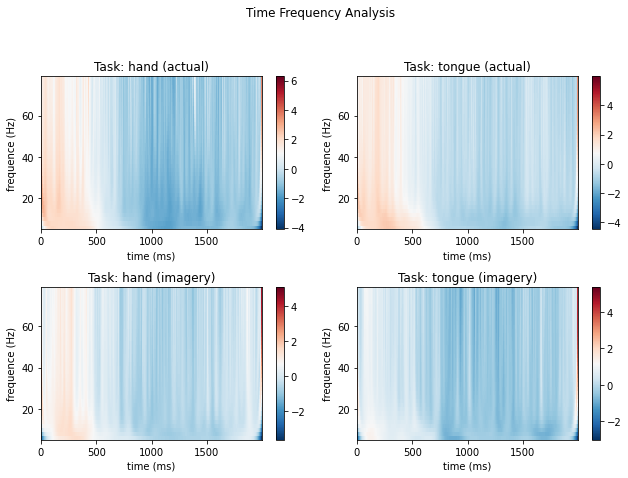

In [25]:
# @title Plot Spectogram of All 4 Data


# Plot All 4 Power Data
f, axes = plt.subplots(2, 2, figsize=(9,6))
time_range=range(2000)

ax1 = axes[0, 0]
c1 = ax1.pcolor(time_range, freqs, power_hand_real_all, cmap='RdBu_r') 
ax1.set_title("Task: hand (actual)")
ax1.set_xlabel('time (ms)')
ax1.set_ylabel('frequence (Hz)')
f.colorbar(c1, ax=ax1) 

ax2 = axes[0, 1]
c2 = ax2.pcolor(time_range, freqs,  power_tongue_real_all, cmap='RdBu_r') 
ax2.set_title("Task: tongue (actual)")
ax2.set_xlabel('time (ms)')
ax2.set_ylabel('frequence (Hz)')
f.colorbar(c2, ax=ax2) 

ax3 = axes[1, 0]
c3 = ax3.pcolor(time_range, freqs, power_hand_imagery_all, cmap='RdBu_r') 
ax3.set_title("Task: hand (imagery)")
ax3.set_xlabel('time (ms)')
ax3.set_ylabel('frequence (Hz)')
f.colorbar(c3, ax=ax3) 

ax4 = axes[1, 1]
c4 = ax4.pcolor(time_range, freqs,  power_tongue_imagery_all, cmap='RdBu_r') 
ax4.set_title("Task: tongue (imagery)")
ax4.set_xlabel('time (ms)')
ax4.set_ylabel('frequence (Hz)')
f.colorbar(c4, ax=ax4) 

plt.tight_layout()
title = "Time Frequency Analysis"
plt.suptitle(title, x=0.5, y=1.1)
plt.show()

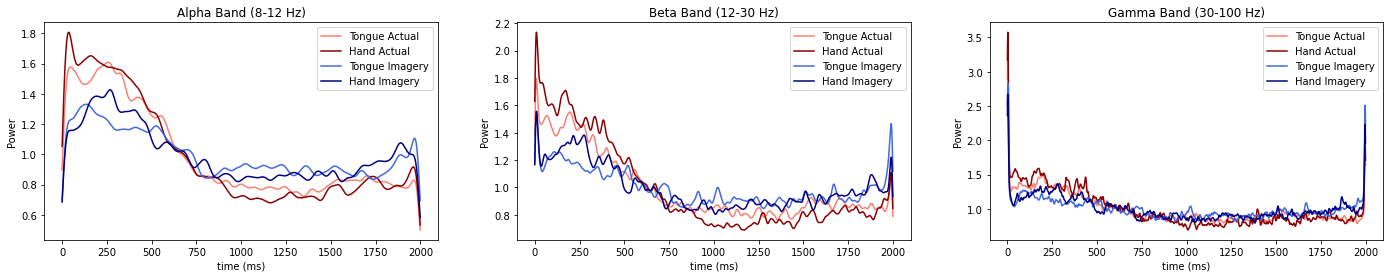

In [18]:
# @title Plot Band Activities (Alpha, Beta, Gamma)

f, axes = plt.subplots(1, 3, figsize=(24, 4))
time_range=range(2000)

# Plot Band Activities

ax1 = axes[0]
ax1.set_prop_cycle(color=['salmon', 'darkred','royalblue', 'navy'])
ax1.plot(time_range,power_tongue_real_alpha_all, label='Tongue Actual')
ax1.plot(time_range,power_hand_real_alpha_all, label='Hand Actual')
ax1.plot(time_range,power_tongue_imagery_alpha_all, label='Tongue Imagery')
ax1.plot(time_range,power_hand_imagery_alpha_all, label='Hand Imagery')
ax1.set_title("Alpha Band (8-12 Hz)")
ax1.set_xlabel('time (ms)')
ax1.set_ylabel('Power')
ax1.legend()


ax2 = axes[1]
ax2.set_prop_cycle(color=['salmon', 'darkred','royalblue', 'navy'])
ax2.plot(time_range,power_tongue_real_beta_all, label='Tongue Actual')
ax2.plot(time_range,power_hand_real_beta_all, label='Hand Actual')
ax2.plot(time_range,power_tongue_imagery_beta_all, label='Tongue Imagery')
ax2.plot(time_range,power_hand_imagery_beta_all, label='Hand Imagery')
ax2.set_title("Beta Band (12-30 Hz)")
ax2.set_xlabel('time (ms)')
ax2.set_ylabel('Power')
ax2.legend()

ax3 = axes[2]
ax3.set_prop_cycle(color=['salmon', 'darkred','royalblue', 'navy'])
ax3.plot(time_range,power_tongue_real_gamma_all, label='Tongue Actual')
ax3.plot(time_range,power_hand_real_gamma_all, label='Hand Actual')
ax3.plot(time_range,power_tongue_imagery_gamma_all, label='Tongue Imagery')
ax3.plot(time_range,power_hand_imagery_gamma_all, label='Hand Imagery')
ax3.set_title("Gamma Band (30-100 Hz)")
ax3.set_xlabel('time (ms)')
ax3.set_ylabel('Power')
ax3.legend()


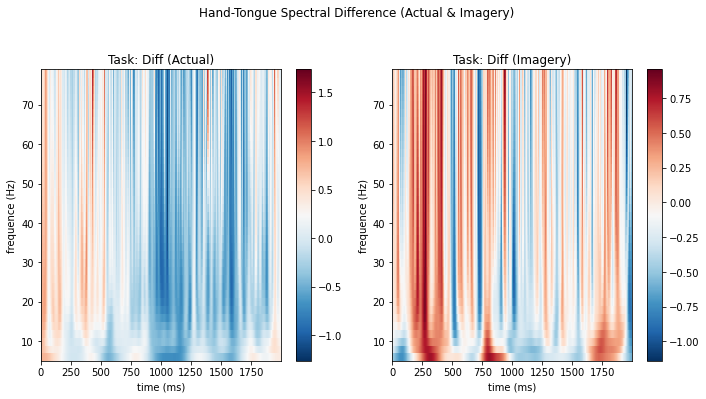

In [21]:
# @title Plot Power Difference (Hand-Tongue) of Spectogram

f, axes = plt.subplots(1, 2, figsize=(10,5))
time_range=range(2000)

# Calculate Hand-Tongue (Actual, Imagery) and Plot

ax1 = axes[0]
c1 = ax1.pcolor(time_range, freqs, power_hand_real_all-power_tongue_real_all, cmap='RdBu_r') 
ax1.set_title("Task: Diff (Actual)")
ax1.set_xlabel('time (ms)')
ax1.set_ylabel('frequence (Hz)')
f.colorbar(c1, ax=ax1) 

ax2 = axes[1]
c2 = ax2.pcolor(time_range, freqs,  power_hand_imagery_all-power_tongue_imagery_all, cmap='RdBu_r') 
ax2.set_title("Task: Diff (Imagery)")
ax2.set_xlabel('time (ms)')
ax2.set_ylabel('frequence (Hz)')
f.colorbar(c2, ax=ax2) 

plt.tight_layout()
title = "Hand-Tongue Spectral Difference (Actual & Imagery)"
plt.suptitle(title, x=0.5, y=1.1)
plt.show()